# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
# from ilqr.examples.DampingPendulum import DampingPendulumDynamics

/home/stone/miniconda3/envs/koopman/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [13]:
from ilqr.dynamics import FiniteDiffDynamics
from scipy.integrate import odeint
import scipy.linalg
state_size = 4  # [position, velocity]
action_size = 2  # [force]


def DoublePendulum(y,t, u):
    th1,th2,dth1,dth2 = y
    u = np.array(u).reshape(2,1)
    f = np.zeros(4)
    g = 9.8
    l1 = 1.0
    l2 = 1.0
    m1 = 1.0
    m2 = 1.0
    c2 = np.cos(th2)
    s2 = np.sin(th2)
    M = np.zeros((2,2))
    M[0,0] = m1*l1**2+m2*(l1**2+2*l1*l2*c2+l2**2)
    M[0,1] = m2*(l1*l2*c2+l2**2)
    M[1,0] = m2*(l1*l2*c2+l2**2)
    M[1,1] = m2*l2**2
    C = np.zeros((2,1))
    C[0,0] = -m2*l1*l2*s2*(2*dth1*dth2+dth2**2)
    C[1,0] = m2*l1*l2*dth1**2*s2
    G = np.zeros((2,1))
    G[0,0] = (m1+m2)*l1*g*np.cos(th1)+m2*g*l2*np.cos(th1+th2)
    G[1,0] = m2*g*l2*np.cos(th1+th2)
    Minv = scipy.linalg.pinv2(M)
    ddth = np.dot(Minv,(u-C-G)).reshape(-1)
    f[0] = dth1
    f[1] = dth2
    f[2] = ddth[0]
    f[3] = ddth[1]
    return f

def f(x, u, i):
    """Dynamics model function.

    Args:
        x: State vector [state_size].
        u: Control vector [action_size].
        i: Current time step.

    Returns:
        Next state vector [state_size].
    """
    dt = 0.01
    sn = odeint(DoublePendulum, x, [0, dt], args=(u,))


    return sn[-1,:]

# NOTE: Unlike with AutoDiffDynamics, this is instantaneous, but will not be
# as accurate.
dynamics = FiniteDiffDynamics(f, state_size, action_size)

In [14]:
# Note that the augmented state is not all 0.
x_goal = np.array([1.2, -0.8,0.0,0.0])
Q = np.eye(dynamics.state_size)
Q[:2,:2] = 5*np.eye(2)
Q[2:4,2:4] = 0.01*np.eye(2)
R = np.eye(2)
Q_terminal = Q.copy()
# R = 0.01*np.eye(1)
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [15]:
N = 200
x0 = np.array([0.,0.,0.,0.])
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [16]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=20, on_iteration=on_iteration)

/tmp/ipykernel_20368/4048400655.py:30: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  Minv = scipy.linalg.pinv2(M)


iteration 0 accepted 10011.194663472712 [-1.65639298 -1.63575033  2.67166148  1.695972  ]
iteration 1 accepted 9740.569737389236 [-1.45742735 -1.83491305  2.74076935  1.8256572 ]
iteration 2 accepted 9725.106309863288 [-1.53238488 -1.76114719  2.65959591  1.83592644]
iteration 3 accepted 9715.522555738795 [-1.50936885 -1.77218685  2.65659366  1.84427009]
iteration 4 accepted 9715.023479616997 [-1.52023997 -1.77597568  2.66885431  1.8191194 ]
iteration 5 accepted 9714.366529508698 [-1.52138711 -1.76330256  2.64616151  1.84069035]
iteration 6 accepted 9714.34342224532 [-1.52081692 -1.77142875  2.65966693  1.82509299]
iteration 7 accepted 9714.27170192178 [-1.52385275 -1.7672237   2.65277178  1.82754607]
iteration 8 accepted 9714.207173953944 [-1.52501656 -1.76613242  2.65090354  1.8257906 ]
iteration 9 accepted 9714.149857921288 [-1.52609627 -1.7654284   2.64986911  1.82556016]
iteration 10 converged 9714.147450160546 [-1.52617821 -1.76528065  2.64939081  1.82558056]


In [63]:
def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            # print(ucost)
            loss += ucost
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q),(observations[:,s]-x_ref))
        # print(xcost)
        loss += xcost
    return loss
loss = Cost(xs.T,us,Q,R,x_goal)
print(loss)

606.7727146011857


In [56]:
loss = Cost(xs,us,Q,R,x_goal)
print(loss)

IndexError: invalid index to scalar variable.

In [50]:
t = np.arange(N) * 0.02
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

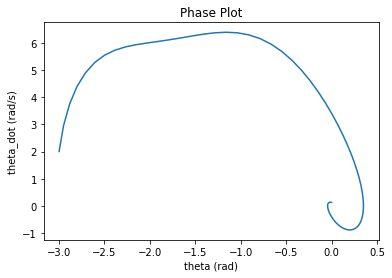

In [51]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

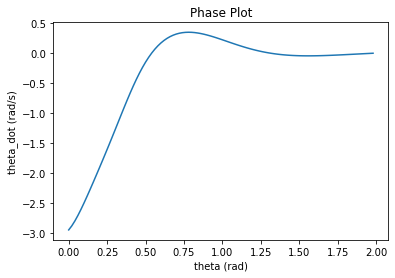

In [52]:
_ = plt.plot(t, theta[1:])
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

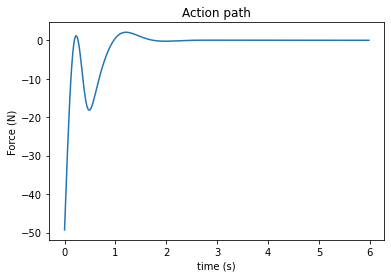

In [45]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

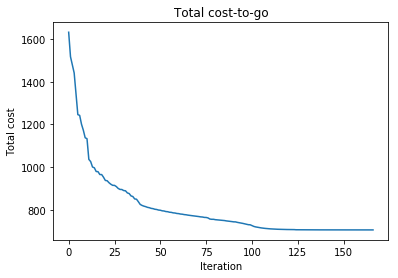

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")